In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import os

In [3]:
directory="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/OctData/LS-3"
Data=np.zeros((2,2))
startindex=10
endindex=startindex+30
for i in range(startindex,endindex):
    #print(i)
    path=os.path.join(directory,"LSdate0_"+str(i)+".txt")
    df=np.loadtxt(path,delimiter="\t")
    Data=np.concatenate((Data,df.T),axis=1)

Data[1]=Data[1]-Data[1][0] #who needs time data?
Data[0]=Data[0]/2 #Convert to PGA1 units

#First value is low so remove it
index=2
newVData=Data[0][index:-1]
newTData=Data[1][index:-1]-Data[1][index] #who needs time data?
newData=np.array([newVData.T,newTData.T])
print(newData)

fsData=1/np.mean(np.diff(newData[1])) #calculate sampling rate
print(fsData)

[[1.43649341e+00 1.43650898e+00 1.43651707e+00 ... 1.24401677e+00
  1.24398892e+00 1.24400000e+00]
 [0.00000000e+00 2.37107277e-03 4.69684601e-03 ... 9.02297062e+03
  9.02297297e+03 9.02297531e+03]]
425.5800183424822


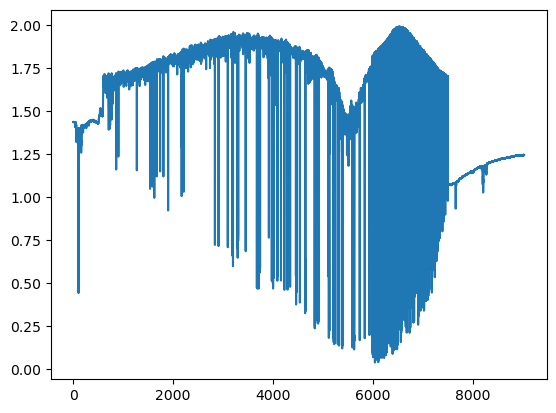

In [4]:
plt.plot(newData[1],newData[0])

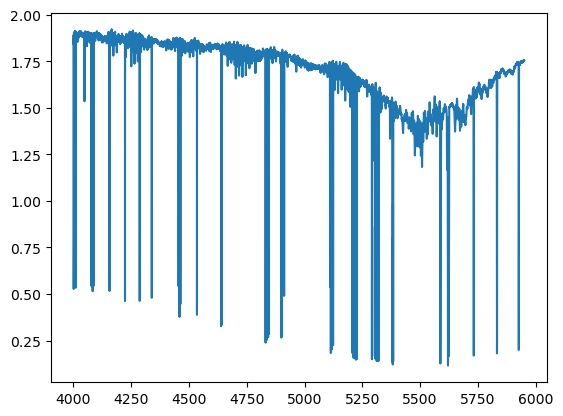

In [5]:
#Get interesting part of data
slicestart=np.where(newData[1]>4000)[0][0]
endstart=np.where(newData[1]>5950)[0][0]
slicedData=np.array([newData[0][slicestart:endstart],newData[1][slicestart:endstart]])
#plt.plot(slicedData[1],slicedData[0])
#plt.show()
plt.plot(slicedData[1],slicedData[0])
#plt.xlim(5500,5750)
plt.show()


27442
1510
3388
829909 0.03896692287949643


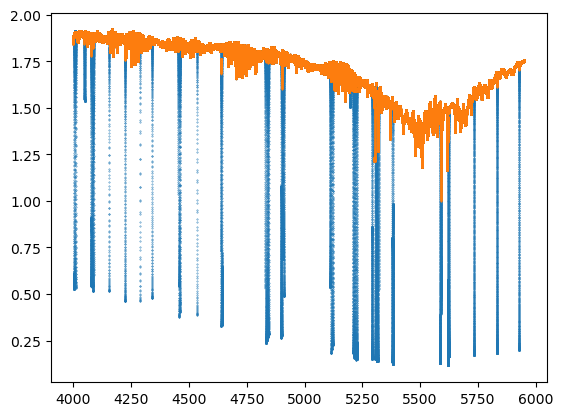

In [79]:
#Procedure: Derivative cutoff, short time cutoff, lowerbound cutoff
#consts:
derivCut=0.75 #slope cutoff point, V/s
pointsaroundDeriv=40
tBreaks=5/fsData # size of time breaks to look at, seconds
maxBreakSize=1.5 #seconds
flatCutoff=1 #V

derivative=np.diff(slicedData[0])/np.diff(slicedData[1]) #calculate slope at each point
derivative=np.insert(derivative,0,0) #add a zero to make indices line up

remove = np.where(np.abs(derivative)>=derivCut)[0] #find indices where derivative is larger than cutoff
newremove=np.unique(np.ndarray.flatten(np.array([np.ones(2*pointsaroundDeriv+1)*i+np.arange(-1*pointsaroundDeriv,pointsaroundDeriv+1,1) for i in remove]))).astype(int)
#print(remove)
print(len(newremove))
new_V=np.delete(slicedData[0],newremove) #remove those indices
new_T=np.delete(slicedData[1],newremove)
derivCleanedData=np.array([new_V,new_T])

#leaves the bottom of the spike dips and a short period of the unwanted data.

diffArray=np.diff(derivCleanedData[1],prepend=0) #get difference

breaks=np.where(diffArray>tBreaks)[0] #find potential points for time breaks
breaksloc=np.where(np.diff(derivCleanedData[1][breaks],prepend=0)<maxBreakSize)[0] #find actual points

#deletebtwn brekasloc-1->breaksloc for each entry in breaksloc
removedRange=np.array([])
for i in range(len(breaksloc)):
    removedRange=np.append(removedRange,np.linspace(breaks[breaksloc[i]],breaks[breaksloc[i]-1],1+breaks[breaksloc[i]]-breaks[breaksloc[i]-1]))
print(len(removedRange))
newCleanedVData=np.delete(derivCleanedData[0],removedRange.astype(int))
newCleanedTData=np.delete(derivCleanedData[1],removedRange.astype(int))
#plt.show()


belowCut=np.where(newCleanedVData<flatCutoff)[0]
print(len(belowCut))
cleanedData=np.array([np.delete(newCleanedVData,belowCut),np.delete(newCleanedTData,belowCut)])

plt.scatter(slicedData[1],slicedData[0],s=0.1)
#plt.scatter(derivCleanedData[1],derivCleanedData[0],s=0.1)
#plt.scatter(newCleanedTData,newCleanedVData,s=0.1)
plt.scatter(cleanedData[1],cleanedData[0],s=0.1)
print(len(slicedData[0]),(len(slicedData[0])-len(cleanedData[0]))/len(slicedData[0]))
#plt.xlim(4830,4847)
#plt.xlim(5560,5650)
#plt.xlim(5580,5592)
#plt.xlim(5586,5592)
#plt.xlim(5110,5125)
#plt.ylim(1.64,1.7)

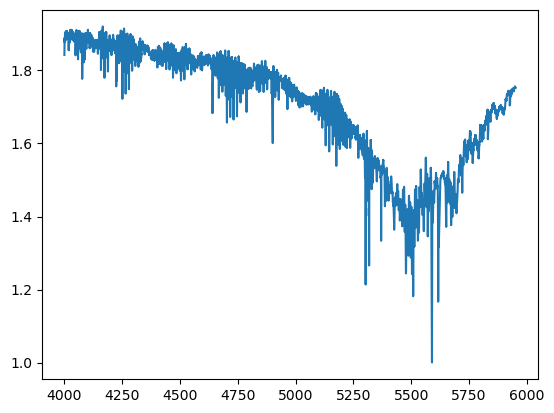

In [52]:
plt.plot(cleanedData[1],cleanedData[0])
#plt.xlim(4890,4905)

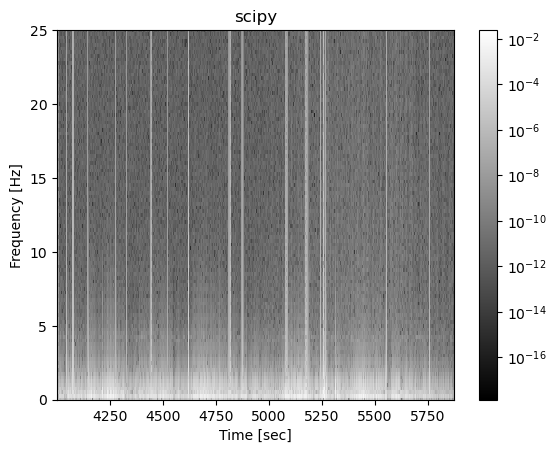

In [77]:
f, t, Sxx = scipy.signal.spectrogram(cleanedData[0], fsData,nperseg=int(fsData*4),detrend="linear")
plt.pcolormesh(t+cleanedData[1][0], f, Sxx,cmap="gray",norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()))
plt.ylim(0,25)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("scipy")
plt.show()
